In [1]:
!pip install transformers datasets tokenizers
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -qq cornell_movie_dialogs_corpus.zip
!rm cornell_movie_dialogs_corpus.zip
!mkdir datasets
!mv cornell\ movie-dialogs\ corpus/movie_conversations.txt ./datasets
!mv cornell\ movie-dialogs\ corpus/movie_lines.txt ./datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
--2024-11-15 05:09:05--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207

In [2]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam

# 1 ) Tokenization (Word Piece Tokenizer)

[Huggingface WordPieceTokenizer](https://huggingface.co/learn/nlp-course/chapter6/6?fw=pt)

The tokenizer's primary job is to split the input text into smaller tokens. These tokens are usually words, subwords (WordPiece tokens), or characters, depending on the specific tokenizer and its configuration.

Subword Tokenization (WordPiece): BERT often uses subword tokenization, where words are further divided into smaller units called subword tokens. For instance, "unhappiness" might be broken down into ["un", "##hap", "##piness"]


By dividing the frequency of the pair by the product of the frequencies of each of its parts, the algorithm prioritizes the merging of pairs where the individual parts are less frequent in the vocabulary.

**score=(freq_of_pair)/(freq_of_first_element×freq_of_second_element)**

## 1.1 Tokenizer from Scratch

In [3]:
from collections import defaultdict
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

### get the frequency of each word ###
word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    print(new_words)
    for word in new_words:
        word_freqs[word] += 1

print(f"\nFinal Word Frequency: {word_freqs}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

['This', 'is', 'the', 'Hugging', 'Face', 'Course', '.']
['This', 'chapter', 'is', 'about', 'tokenization', '.']
['This', 'section', 'shows', 'several', 'tokenizer', 'algorithms', '.']
['Hopefully', ',', 'you', 'will', 'be', 'able', 'to', 'understand', 'how', 'they', 'are', 'trained', 'and', 'generate', 'tokens', '.']

Final Word Frequency: defaultdict(<class 'int'>, {'This': 3, 'is': 2, 'the': 1, 'Hugging': 1, 'Face': 1, 'Course': 1, '.': 4, 'chapter': 1, 'about': 1, 'tokenization': 1, 'section': 1, 'shows': 1, 'several': 1, 'tokenizer': 1, 'algorithms': 1, 'Hopefully': 1, ',': 1, 'you': 1, 'will': 1, 'be': 1, 'able': 1, 'to': 1, 'understand': 1, 'how': 1, 'they': 1, 'are': 1, 'trained': 1, 'and': 1, 'generate': 1, 'tokens': 1})


In [4]:
### split all word into alphabet ###
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
print(f'All alphabets: {alphabet}')

### insert special token and subword ###
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()
splits = {word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)] for word in word_freqs.keys()}
print(f'\nSplitted Words: {splits}')

All alphabets: ['##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y']

Splitted Words: {'This': ['T', '##h', '##i', '##s'], 'is': ['i', '##s'], 'the': ['t', '##h', '##e'], 'Hugging': ['H', '##u', '##g', '##g', '##i', '##n', '##g'], 'Face': ['F', '##a', '##c', '##e'], 'Course': ['C', '##o', '##u', '##r', '##s', '##e'], '.': ['.'], 'chapter': ['c', '##h', '##a', '##p', '##t', '##e', '##r'], 'about': ['a', '##b', '##o', '##u', '##t'], 'tokenization': ['t', '##o', '##k', '##e', '##n', '##i', '##z', '##a', '##t', '##i', '##o', '##n'], 'section': ['s', '##e', '##c', '##t', '##i', '##o', '##n'], 'shows': ['s', '##h', '##o', '##w', '##s'], 'several': ['s', '##e', '##v', '##e', '##r', '##a', '##l'], 'tokenizer': ['t', '##o', '##k', '##e', '##n', '##i', '##z', '##e', '##r'], 'algorithms': ['a', '##l', '##g'

In [5]:
 ### compute score for merging ###
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)

    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

pair_scores = compute_pair_scores(splits)
print(f'Scores for each Pair: {pair_scores}')

Scores for each Pair: {('T', '##h'): 0.125, ('##h', '##i'): 0.03409090909090909, ('##i', '##s'): 0.02727272727272727, ('i', '##s'): 0.1, ('t', '##h'): 0.03571428571428571, ('##h', '##e'): 0.011904761904761904, ('H', '##u'): 0.1, ('##u', '##g'): 0.05, ('##g', '##g'): 0.0625, ('##g', '##i'): 0.022727272727272728, ('##i', '##n'): 0.01652892561983471, ('##n', '##g'): 0.022727272727272728, ('F', '##a'): 0.14285714285714285, ('##a', '##c'): 0.07142857142857142, ('##c', '##e'): 0.023809523809523808, ('C', '##o'): 0.07692307692307693, ('##o', '##u'): 0.046153846153846156, ('##u', '##r'): 0.022222222222222223, ('##r', '##s'): 0.022222222222222223, ('##s', '##e'): 0.004761904761904762, ('c', '##h'): 0.125, ('##h', '##a'): 0.017857142857142856, ('##a', '##p'): 0.07142857142857142, ('##p', '##t'): 0.07142857142857142, ('##t', '##e'): 0.013605442176870748, ('##e', '##r'): 0.026455026455026454, ('a', '##b'): 0.2, ('##b', '##o'): 0.038461538461538464, ('##u', '##t'): 0.02857142857142857, ('t', '##o')

In [6]:
### finding pair with best score ###
best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)
vocab.append("ab")

### merge pair ###
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

splits = merge_pair("a", "##b", splits)
print(splits["about"])

('a', '##b') 0.2
['ab', '##o', '##u', '##t']


In [7]:
### keep looping to merge more pair
vocab_size = 70
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

print(f'Final Vocab: {vocab}')

Final Vocab: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y', 'ab', '##fu', 'Fa', 'Fac', '##ct', '##ful', '##full', '##fully', 'Th', 'ch', '##hm', 'cha', 'chap', 'chapt', '##thm', 'Hu', 'Hug', 'Hugg', 'sh', 'th', 'is', '##thms', '##za', '##zat', '##ut']


In [8]:
### ro encode a word ###
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

print(encode_word("Hugging"))
print(encode_word("HOgging"))

['Hugg', '##i', '##n', '##g']
['[UNK]']


## 1.2 Tokenizer Training

In [9]:
### data processing
MAX_LEN = 64

### loading all data into memory
corpus_movie_conv = './datasets/movie_conversations.txt'
corpus_movie_lines = './datasets/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

### splitting text using special lines
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

### generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []

        if i == len(ids) - 1:
            break

        first = lines_dic[ids[i]].strip()
        second = lines_dic[ids[i+1]].strip()

        qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
        qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
        pairs.append(qa_pairs)

# sample
print(pairs[20])

["I really, really, really wanna go, but I can't. Not unless my sister goes.", "I'm workin' on it. But she doesn't seem to be goin' for him."]


In [10]:
# WordPiece tokenizer

### save data as txt file
os.mkdir('./data')
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]
print(len(paths))

100%|██████████| 221616/221616 [00:00<00:00, 371641.67it/s]

22


In [11]:
# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### Training tokenizer ###
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

# Adjust 'paths' to point to your training text files.
tokenizer.train(
    files=paths,
    vocab_size=30_000,
    min_frequency=5,
    limit_alphabet=1000,
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
)

# Save tokenizer model
os.makedirs('./bert-it-1', exist_ok=True)
tokenizer.save_model('./bert-it-1', 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)

# Sample tokenization to test the tokenizer
token_ids = tokenizer('I like surfboarding!')['input_ids']
print(token_ids)
print(tokenizer.convert_ids_to_tokens(token_ids))

Using device: cuda
[1, 48, 250, 4033, 3588, 154, 5, 2]
['[CLS]', 'i', 'like', 'surf', '##board', '##ing', '!', '[SEP]']


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2107: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


# 2) Pre-processing

In [12]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):
        # Get random sentence pair
        t1, t2, is_next_label = self.get_sent(item)

        # Replace random words with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Add special tokens
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Combine sentences
        segment_label = ([1] * len(t1) + [2] * len(t2))[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]']] * (self.seq_len - len(bert_input))
        bert_input.extend(padding)
        bert_label.extend(padding)
        segment_label.extend(padding)

        # Move to device
        output = {
            "bert_input": torch.tensor(bert_input, device=device),
            "bert_label": torch.tensor(bert_label, device=device),
            "segment_label": torch.tensor(segment_label, device=device),
            "is_next": torch.tensor(is_next_label, device=device)
        }

        return output

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # Replace 15% of tokens
        for i, token in enumerate(tokens):
            prob = random.random()
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15
                if prob < 0.8:
                    output.extend([self.tokenizer.vocab['[MASK]']] * len(token_id))
                elif prob < 0.9:
                    output.extend([random.randrange(len(self.tokenizer.vocab))] * len(token_id))
                else:
                    output.extend(token_id)
                output_label.extend(token_id)
            else:
                output.extend(token_id)
                output_label.extend([0] * len(token_id))

        # Flatten output
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        t1, t2 = self.get_corpus_line(index)
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        return self.lines[random.randrange(len(self.lines))][1]


In [13]:
# Test
train_data = BERTDataset(pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Fetch a batch and check device
sample_data = next(iter(train_loader))
print('Batch Size:', sample_data['bert_input'].size())

# Sample output from dataset
result = train_data[random.randrange(len(train_data))]
print(result)

Batch Size: torch.Size([32, 64])
{'bert_input': tensor([   1,  146,  247,  150,  308,  359,   17,    2,    3, 4354,  211,    3,
         528,   17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], device='cuda:0'), 'bert_label': tensor([   0,    0,    0,    0,  308,    0,    0,    0,   48,    0,    0, 2543,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], device='cuda:0'), 'segment_label': tensor([1, 1, 1, 1,

# 3) Modeling

In [14]:
class PositionalEmbedding(torch.nn.Module):
    def __init__(self, d_model, max_len=128):
        super().__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.requires_grad_(False)

        for pos in range(max_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))

        # Register buffer so it moves with the model to CUDA
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return self.pe[:, :x.size(1)].to(x.device)

class BERTEmbedding(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, seq_len=64, dropout=0.1):
        super().__init__()
        self.embed_size = embed_size
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0).to(device)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0).to(device)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len).to(device)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

### testing
embed_layer = BERTEmbedding(vocab_size=len(tokenizer.vocab), embed_size=768, seq_len=MAX_LEN)
embed_result = embed_layer(sample_data['bert_input'], sample_data['segment_label'])
print(embed_result.size())

torch.Size([32, 64, 768])


In [27]:
import torch
import math

class MultiHeadedAttention(torch.nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        # Linear layers for query, key, and value
        self.query = torch.nn.Linear(d_model, d_model).to(device)
        self.key = torch.nn.Linear(d_model, d_model).to(device)
        self.value = torch.nn.Linear(d_model, d_model).to(device)
        self.output_linear = torch.nn.Linear(d_model, d_model).to(device)

        # Define learnable parameters beta and gamma
        self.beta = torch.nn.Parameter(torch.tensor(0.1))  # Initialize as needed
        self.gamma = torch.nn.Parameter(torch.tensor(1.0))  # Initialize as needed
        self.r = 8  # The given value for r in the approximation

    def approx_exp(self, x):
        # Use the provided approximation for exp(x) with r = 8
        x = torch.clamp(x, min=-100.0, max=100.0)

        return (1 + x / (2 ** self.r)) ** (2 ** self.r)

    def consmax(self, scores):
        # Apply approximation only to (scores - beta)
        approx_scores = self.approx_exp(scores - self.beta)
        # Scale by gamma after the approximation
        scaled_scores = approx_scores / self.gamma
        # Normalize to sum to 1 along the last dimension to keep it a probability distribution
        return scaled_scores / (scaled_scores.sum(dim=-1, keepdim=True)+1e-8)

    def forward(self, query, key, value, mask):
        # Compute Q, K, V projections
        query, key, value = self.query(query), self.key(key), self.value(value)
        query, key, value = [x.view(x.size(0), -1, self.heads, self.d_k).permute(0, 2, 1, 3) for x in [query, key, value]]

        # Scaled dot-product attention with ConSMax
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(self.d_k)
        scores = scores.masked_fill(mask == 0, torch.tensor(-1e9, device=scores.device))

        # Replace softmax with ConSMax
        weights = self.consmax(scores)
        weights = self.dropout(weights)

        # Compute the context
        context = torch.matmul(weights, value)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.size(0), -1, self.heads * self.d_k)

        return self.output_linear(context)

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super().__init__()
        self.fc1 = torch.nn.Linear(d_model, middle_dim).to(device)
        self.fc2 = torch.nn.Linear(middle_dim, d_model).to(device)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        return self.fc2(self.dropout(out))

class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model=768, heads=12, feed_forward_hidden=768 * 4, dropout=0.1):
        super().__init__()
        self.layernorm = torch.nn.LayerNorm(d_model).to(device)
        self.self_multihead = MultiHeadedAttention(heads, d_model).to(device)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden).to(device)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        return self.layernorm(feed_forward_out + interacted)

### Testing
mask = (sample_data['bert_input'] > 0).unsqueeze(1).repeat(1, sample_data['bert_input'].size(1), 1).unsqueeze(1).to(device)
embed_layer = BERTEmbedding(vocab_size=len(tokenizer.vocab), embed_size=768, seq_len=MAX_LEN).to(device)
embed_result = embed_layer(sample_data['bert_input'], sample_data['segment_label'])

transformer_block = EncoderLayer().to(device)
transformer_result = transformer_block(embed_result, mask)
print(transformer_result.size())


torch.Size([32, 64, 768])


In [28]:
import torch

class BERT(torch.nn.Module):
    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads
        self.feed_forward_hidden = d_model * 4
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model).to(device)
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout).to(device) for _ in range(n_layers)]
        )

    def forward(self, x, segment_info):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1).to(device)
        x = self.embedding(x.to(device), segment_info.to(device))

        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

class NextSentencePrediction(torch.nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2).to(device)
        # Initialize beta and gamma as learnable parameters
        self.beta = torch.nn.Parameter(torch.tensor(1.0)).to(device)
        self.gamma = torch.nn.Parameter(torch.tensor(1.0)).to(device)
        self.r = 8  # The given value for r in the approximation

    def approx_exp(self, x):
        # Use the provided approximation for exp(x) with r = 8
        x = torch.clamp(x, min=-100.0, max=100.0)
        return (1 + x / (2 ** self.r)) ** (2 ** self.r)

    def forward(self, x):
        logits = self.linear(x[:, 0])
        # Apply the approximation only to (logits - beta) and then divide by gamma
        consmax_scores = self.approx_exp(logits - self.beta) / self.gamma
        consmax_probs = consmax_scores / (consmax_scores.sum(dim=-1, keepdim=True) + 1e-8)

        return torch.log(consmax_probs + 1e-8)  # for stability
  # Return log probabilities for compatibility

class MaskedLanguageModel(torch.nn.Module):
    def __init__(self, hidden, vocab_size):
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size).to(device)
        # Initialize beta and gamma as learnable parameters
        self.beta = torch.nn.Parameter(torch.tensor(1.0)).to(device)
        self.gamma = torch.nn.Parameter(torch.tensor(1.0)).to(device)
        self.r = 8  # The given value for r in the approximation

    def approx_exp(self, x):
        # Use the provided approximation for exp(x) with r = 8
        x = torch.clamp(x, min=-100.0, max=100.0)

        return (1 + x / (2 ** self.r)) ** (2 ** self.r)

    def forward(self, x):
        logits = self.linear(x)
        # Apply the approximation only to (logits - beta) and then divide by gamma
        consmax_scores = self.approx_exp(logits - self.beta) / self.gamma
        consmax_probs = consmax_scores / (consmax_scores.sum(dim=-1, keepdim=True) + 1e-8)

        return torch.log(consmax_probs + 1e-8)  # for stability
  # Return log probabilities for compatibility

class BERTLM(torch.nn.Module):
    def __init__(self, bert: BERT, vocab_size):
        super().__init__()
        self.bert = bert.to(device)
        self.next_sentence = NextSentencePrediction(self.bert.d_model).to(device)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size).to(device)

    def forward(self, x, segment_label):
        x = self.bert(x.to(device), segment_label.to(device))
        return self.next_sentence(x), self.mask_lm(x)

# Testing
bert_model = BERT(len(tokenizer.vocab)).to(device)
bert_result = bert_model(sample_data['bert_input'], sample_data['segment_label'])
print(bert_result.size())

bert_lm = BERTLM(bert_model, len(tokenizer.vocab)).to(device)
final_result = bert_lm(sample_data['bert_input'], sample_data['segment_label'])
print(final_result[0].size(), final_result[1].size())


torch.Size([32, 64, 768])
torch.Size([32, 2]) torch.Size([32, 64, 21160])


# 4) Training

In [29]:
### optimizer
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

Total Parameters: 117562818


EP_train:0:   1%|| 1/70 [00:00<00:39,  1.73it/s]

{'epoch': 0, 'iter': 0, 'avg_loss': 10.931907653808594, 'avg_acc': 31.25, 'loss': 10.931907653808594}


EP_train:0:  16%|| 11/70 [00:05<00:30,  1.93it/s]

{'epoch': 0, 'iter': 10, 'avg_loss': 10.744172703136098, 'avg_acc': 48.57954545454545, 'loss': 10.529524803161621}


EP_train:0:  30%|| 21/70 [00:10<00:24,  2.04it/s]

{'epoch': 0, 'iter': 20, 'avg_loss': 10.550786790393648, 'avg_acc': 49.107142857142854, 'loss': 10.188624382019043}


EP_train:0:  44%|| 31/70 [00:15<00:19,  2.04it/s]

{'epoch': 0, 'iter': 30, 'avg_loss': 10.39140070638349, 'avg_acc': 48.79032258064516, 'loss': 9.989623069763184}


EP_train:0:  59%|| 41/70 [00:20<00:14,  1.97it/s]

{'epoch': 0, 'iter': 40, 'avg_loss': 10.265227806277391, 'avg_acc': 47.71341463414634, 'loss': 9.795262336730957}


EP_train:0:  73%|| 51/70 [00:25<00:09,  1.98it/s]

{'epoch': 0, 'iter': 50, 'avg_loss': 10.143056495516907, 'avg_acc': 47.85539215686275, 'loss': 9.612273216247559}


EP_train:0:  87%|| 61/70 [00:30<00:04,  1.94it/s]

{'epoch': 0, 'iter': 60, 'avg_loss': 10.02217743044994, 'avg_acc': 49.48770491803279, 'loss': 9.361632347106934}


EP_train:0: 100%|| 70/70 [00:34<00:00,  2.02it/s]


EP0, train:             avg_loss=9.908264146532332,             total_acc=49.50361010830325


EP_train:1:   1%|| 1/70 [00:00<00:34,  1.98it/s]

{'epoch': 1, 'iter': 0, 'avg_loss': 9.371794700622559, 'avg_acc': 59.375, 'loss': 9.371794700622559}


EP_train:1:  16%|| 11/70 [00:05<00:28,  2.06it/s]

{'epoch': 1, 'iter': 10, 'avg_loss': 8.915388020602139, 'avg_acc': 51.42045454545454, 'loss': 8.81196117401123}


EP_train:1:  30%|| 21/70 [00:10<00:25,  1.94it/s]

{'epoch': 1, 'iter': 20, 'avg_loss': 8.828060649690174, 'avg_acc': 51.636904761904766, 'loss': 8.672607421875}


EP_train:1:  44%|| 31/70 [00:15<00:19,  2.01it/s]

{'epoch': 1, 'iter': 30, 'avg_loss': 8.749464004270491, 'avg_acc': 50.50403225806451, 'loss': 8.662776947021484}


EP_train:1:  59%|| 41/70 [00:20<00:15,  1.92it/s]

{'epoch': 1, 'iter': 40, 'avg_loss': 8.693963585830316, 'avg_acc': 50.609756097560975, 'loss': 8.644402503967285}


EP_train:1:  73%|| 51/70 [00:25<00:09,  2.01it/s]

{'epoch': 1, 'iter': 50, 'avg_loss': 8.630183406904631, 'avg_acc': 50.06127450980392, 'loss': 8.334009170532227}


EP_train:1:  87%|| 61/70 [00:30<00:04,  2.03it/s]

{'epoch': 1, 'iter': 60, 'avg_loss': 8.56614453675317, 'avg_acc': 49.48770491803279, 'loss': 8.21655559539795}


EP_train:1: 100%|| 70/70 [00:34<00:00,  2.00it/s]


EP1, train:             avg_loss=8.515220771517072,             total_acc=49.72924187725632


EP_train:2:   1%|| 1/70 [00:00<00:34,  1.98it/s]

{'epoch': 2, 'iter': 0, 'avg_loss': 8.006265640258789, 'avg_acc': 56.25, 'loss': 8.006265640258789}


EP_train:2:  16%|| 11/70 [00:05<00:29,  2.02it/s]

{'epoch': 2, 'iter': 10, 'avg_loss': 8.143502192063766, 'avg_acc': 50.28409090909091, 'loss': 8.144774436950684}


EP_train:2:  30%|| 21/70 [00:10<00:25,  1.95it/s]

{'epoch': 2, 'iter': 20, 'avg_loss': 8.135357516152519, 'avg_acc': 48.95833333333333, 'loss': 7.843062877655029}


EP_train:2:  44%|| 31/70 [00:15<00:19,  2.00it/s]

{'epoch': 2, 'iter': 30, 'avg_loss': 8.111322326044883, 'avg_acc': 50.0, 'loss': 8.076111793518066}


EP_train:2:  59%|| 41/70 [00:20<00:14,  1.99it/s]

{'epoch': 2, 'iter': 40, 'avg_loss': 8.070348053443723, 'avg_acc': 50.609756097560975, 'loss': 8.03099536895752}


EP_train:2:  73%|| 51/70 [00:25<00:09,  1.94it/s]

{'epoch': 2, 'iter': 50, 'avg_loss': 8.036542041628968, 'avg_acc': 51.34803921568627, 'loss': 8.123541831970215}


EP_train:2:  87%|| 61/70 [00:30<00:04,  2.00it/s]

{'epoch': 2, 'iter': 60, 'avg_loss': 8.016722483713119, 'avg_acc': 50.7172131147541, 'loss': 7.883663654327393}


EP_train:2: 100%|| 70/70 [00:34<00:00,  2.00it/s]


EP2, train:             avg_loss=8.0000556741442,             total_acc=51.35379061371841


EP_train:3:   1%|| 1/70 [00:00<00:38,  1.81it/s]

{'epoch': 3, 'iter': 0, 'avg_loss': 7.964090347290039, 'avg_acc': 46.875, 'loss': 7.964090347290039}


EP_train:3:  16%|| 11/70 [00:05<00:29,  1.98it/s]

{'epoch': 3, 'iter': 10, 'avg_loss': 7.884027914567427, 'avg_acc': 46.590909090909086, 'loss': 8.163939476013184}


EP_train:3:  30%|| 21/70 [00:10<00:24,  1.98it/s]

{'epoch': 3, 'iter': 20, 'avg_loss': 7.849114190964472, 'avg_acc': 46.726190476190474, 'loss': 7.663050651550293}


EP_train:3:  44%|| 31/70 [00:16<00:20,  1.90it/s]

{'epoch': 3, 'iter': 30, 'avg_loss': 7.815744430788102, 'avg_acc': 47.983870967741936, 'loss': 7.508267879486084}


EP_train:3:  59%|| 41/70 [00:21<00:14,  1.98it/s]

{'epoch': 3, 'iter': 40, 'avg_loss': 7.7928072533956385, 'avg_acc': 48.85670731707317, 'loss': 7.846009731292725}


EP_train:3:  73%|| 51/70 [00:26<00:10,  1.88it/s]

{'epoch': 3, 'iter': 50, 'avg_loss': 7.757513186510871, 'avg_acc': 48.83578431372549, 'loss': 7.01633882522583}


EP_train:3:  87%|| 61/70 [00:31<00:04,  1.96it/s]

{'epoch': 3, 'iter': 60, 'avg_loss': 7.741694958483587, 'avg_acc': 48.77049180327869, 'loss': 7.499792098999023}


EP_train:3: 100%|| 70/70 [00:35<00:00,  1.97it/s]


EP3, train:             avg_loss=7.70817460332598,             total_acc=49.23285198555957


EP_train:4:   1%|| 1/70 [00:00<00:34,  1.98it/s]

{'epoch': 4, 'iter': 0, 'avg_loss': 7.3249101638793945, 'avg_acc': 59.375, 'loss': 7.3249101638793945}


EP_train:4:  16%|| 11/70 [00:05<00:31,  1.89it/s]

{'epoch': 4, 'iter': 10, 'avg_loss': 7.5121471231633965, 'avg_acc': 51.13636363636363, 'loss': 7.390694618225098}


EP_train:4:  30%|| 21/70 [00:10<00:24,  1.97it/s]

{'epoch': 4, 'iter': 20, 'avg_loss': 7.512657892136347, 'avg_acc': 49.702380952380956, 'loss': 7.542484760284424}


EP_train:4:  44%|| 31/70 [00:15<00:20,  1.90it/s]

{'epoch': 4, 'iter': 30, 'avg_loss': 7.475094825990738, 'avg_acc': 49.69758064516129, 'loss': 7.345233917236328}


EP_train:4:  59%|| 41/70 [00:21<00:14,  1.97it/s]

{'epoch': 4, 'iter': 40, 'avg_loss': 7.472514640994188, 'avg_acc': 49.771341463414636, 'loss': 7.593376159667969}


EP_train:4:  73%|| 51/70 [00:26<00:09,  1.96it/s]

{'epoch': 4, 'iter': 50, 'avg_loss': 7.469560623168945, 'avg_acc': 49.81617647058824, 'loss': 7.264882564544678}


EP_train:4:  87%|| 61/70 [00:31<00:04,  1.93it/s]

{'epoch': 4, 'iter': 60, 'avg_loss': 7.463966025680792, 'avg_acc': 50.10245901639344, 'loss': 7.332062244415283}


EP_train:4: 100%|| 70/70 [00:35<00:00,  1.96it/s]


EP4, train:             avg_loss=7.4492542334965295,             total_acc=50.13537906137184


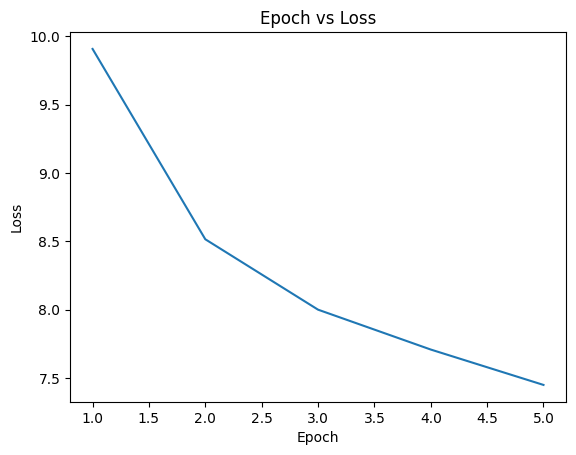

In [30]:
import torch
import tqdm
import matplotlib.pyplot as plt

class BERTTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader=None,
        lr=1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'  # Set default to 'cuda', but can be set to 'cpu' as well
    ):
        # Set device to CUDA or CPU based on availability and argument
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)  # Move model to selected device
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
        )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0).to(self.device)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

        # List to store loss values for plotting
        self.epoch_losses = []

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:
            # 0. Move batch data to the device (GPU or CPU)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))

        epoch_loss = avg_loss / len(data_iter)
        self.epoch_losses.append(epoch_loss)  # Save average loss for this epoch

        print(
            f"EP{epoch}, {mode}: \
            avg_loss={epoch_loss}, \
            total_acc={total_correct * 100.0 / total_element}"
        )

    def plot_loss(self):
        # Plotting epoch vs loss graph
        plt.plot(range(1, len(self.epoch_losses) + 1), self.epoch_losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Epoch vs Loss")
        plt.show()

### Test Block
import random

# Define the fraction you want to use for training (e.g., 1%)
fraction = 0.01
subset_size = int(len(pairs) * fraction)
subset_pairs = random.sample(pairs, subset_size)

# Create dataset and dataloader with the subset
train_data = BERTDataset(subset_pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Initialize model and trainer
bert_model = BERT(len(tokenizer.vocab)).to(device)  # Move model to CUDA (or CPU)
bert_lm = BERTLM(bert_model, len(tokenizer.vocab)).to(device)  # Move model to CUDA (or CPU)
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

# Training loop
epochs = 5
for epoch in range(epochs):
    bert_trainer.train(epoch)

# After training, plot the epoch vs loss graph
bert_trainer.plot_loss()
